# Proyek Sistem Rekomendasi: Anime Recommendation
- Nama: Haiqel Aziizul Hakeem
- Email: a547ybm193@devacademy.id
- ID: haiqelhakeem

## Import

In [1]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2463218 sha256=a6f5ef5241d7a400e8a1bf27f2465fa805345c34a35b57ca7fa7f0825946e17f
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
# # Downgrade NumPy to a compatible version
# !pip install numpy==1.26.4 --force-reinstall

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
!pip install "numpy<2" --upgrade --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise.accuracy import rmse

In [2]:
np.__version__

'1.26.4'

## Data Understanding

Pada bagian ini kita mempelajari data yang akan kita proses. Kita akan melakukan load data dan EDA

### Data Loading

Kita memasukkan dataset menggunakan library `kagglehub` dan `os` untuk input dataset. Setelah dataset diunduh maka kita masukkan ke dalam data frame sesuai dengan file masing-masing.

In [3]:
path = kagglehub.dataset_download("CooperUnion/anime-recommendations-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/anime-recommendations-database


In [4]:
os.listdir(path)

['rating.csv', 'anime.csv']

In [5]:
anime_df = pd.read_csv(path + "/anime.csv")
rating_df = pd.read_csv(path + "/rating.csv")

### EDA

Disini kita melakukan eksplorasi tiap data frame. Dimana kita menggunakan `info()`, `shape`, `isnull()`, dll. untuk mengetahui informasi dataset secara lengkap dan apa saja langkah yang dapat kita lakukan.

In [6]:
# Anime Data Frame preview
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Berdasarkan pada tabel di atas, kita dapat melihat bahwa dataset terdiri dari kolom `anime_id`, `name`, `genre`, `type`, `episodes`, `rating`, dan `members`. <br> `anime_id` : nomor identifikasi tiap anime pada situs MyAnimeList <br> `name` : nama anime <br> `genre` : jenis genre anime <br> `type` : jenis anime tersebut seperti movie atau pun TV series <br> `episodes` : jumlah episode <br> `rating` : nilai rating anime tersebut <br> `members` : jumlah member MAL yang memberikan rating


In [7]:
# Anime df info
anime_df.info()
print("\nShape:", anime_df.shape)
print("\nMissing Values:\n", anime_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB

Shape: (12294, 7)

Missing Values:
 anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64


Data di atas memberikan informasi bahwa dataset anime df ini memiliki tipe data integer, object, dan float. Dengan shape dataset terdiri dari 12294 baris dan 7 kolom, dan terdapat null pada kolom genre, type, dan rating.

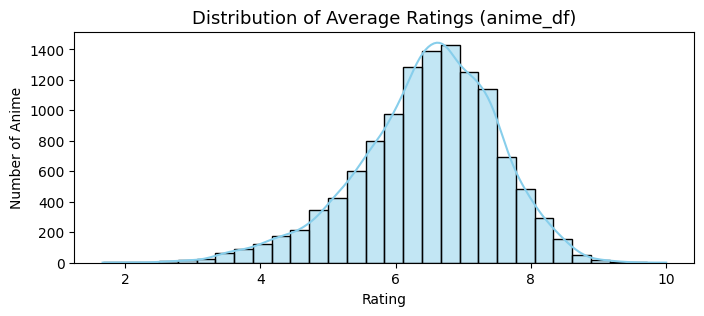

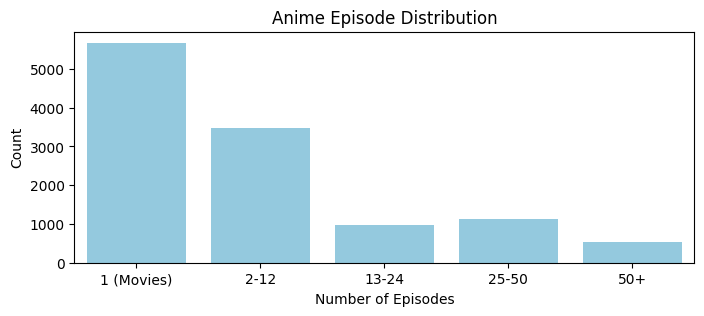

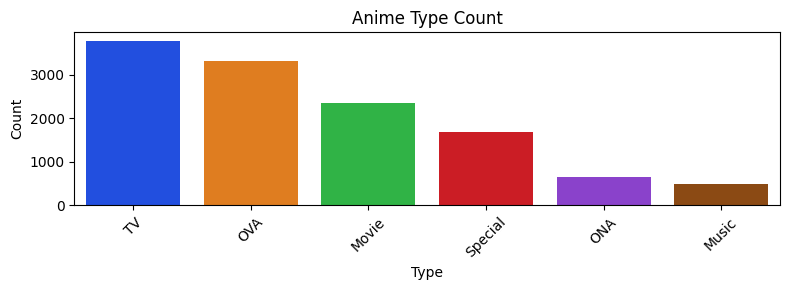

In [8]:
# Average Rating of Anime
plt.figure(figsize=(8, 3))
sns.histplot(anime_df['rating'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Average Ratings (anime_df)', fontsize=13)
plt.xlabel('Rating')
plt.ylabel('Number of Anime')

# Distribution of Anime Episodes
plt.figure(figsize=(8, 3))
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors='coerce')
bins = [1, 2, 13, 25, 50, 100]
labels = ['1 (Movies)', '2-12', '13-24', '25-50', '50+']
episode_cats = pd.cut(anime_df['episodes'].dropna(),
                     bins=bins,
                     labels=labels,
                     right=False)
sns.countplot(x=episode_cats, order=labels, color='skyblue')
plt.title('Anime Episode Distribution')
plt.xlabel('Number of Episodes')
plt.ylabel('Count')

# Distribution of Anime Types
plt.figure(figsize=(8, 3))
sns.countplot(data=anime_df, x='type', order=anime_df['type'].value_counts().index, palette='bright')
plt.title('Anime Type Count')
plt.xlabel('Type')
plt.ylabel('Count')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Berdasarkan plot yang ditampilkan di atas, dapat kita simpulkan bahwa berdasarkan data frame anime df ini:
1. Jumlah rating paling banyak ada di rentan 6-8
2. Jumlah episode paling banyak adalah 1 atau movie lalu disusul oleh dengan jumlah episode 2-12
3. Jenis anime paling banyak adalah TV series lalu disusul oleh OVA

In [9]:
# Rating Data Frame Preview
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Pada rating df ini terdiri dari kolom: <br> `user_id` : Random generated user id <br> `anime_id` : Id number yang diberikan rating oleh user
<br> `rating` : Rating sampai 10 dimana jika value -1 berarti user tersebut menonton tapi tidak memberikan rating.

In [ ]:
# Rating Data Frame info
rating_df.info()
print("\nShape:", rating_df.shape)
print("\nMissing Values:\n", rating_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB

Shape: (7813737, 3)

Missing Values:
 user_id     0
anime_id    0
rating      0
dtype: int64


Berdasarkan informasi di atas, dapat diketahui bahwa rating df ini memiliki tipe data integer dengan shape 7813737 baris dan 3 kolom, serta tidak ada nilai null.

In [ ]:
# Unique Value in rating df
unique_users = rating_df['user_id'].nunique()
print(f"Number of unique users: {unique_users}")

Number of unique users: 73515


Unique value dari kolom user id ini berjumlah 73515, berarti sebanyak itu user yang telah memberikan rating pada data frame ini.

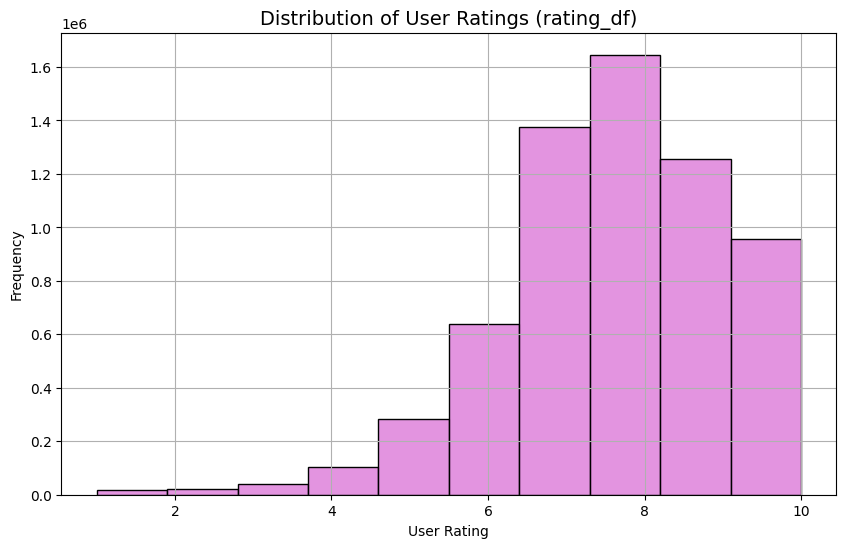

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(rating_df[rating_df['rating'] != -1]['rating'], bins=10, kde=False, color='orchid')
plt.title('Distribution of User Ratings (rating_df)', fontsize=14)
plt.xlabel('User Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Kebanyakan rating yang diberikan oleh user ada di rentang 7-8

## Data Preparation

In [10]:
# Handle Missing Value
# Genre - fill unknown
anime_df['genre'] = anime_df['genre'].fillna('Unknown')

# Type - fill mode
type_mode = anime_df['type'].mode()[0]
anime_df['type'] = anime_df['type'].fillna(type_mode)

# Episodes - type-based imputation
episode_medians = anime_df.groupby('type')['episodes'].median()
anime_df['episodes'] = anime_df.apply(
    lambda row: episode_medians[row['type']] if pd.isna(row['episodes']) else row['episodes'],
    axis=1
)

# Rating - weighted imputation
avg_rating = np.average(
    anime_df['rating'].dropna(),
    weights=anime_df.loc[anime_df['rating'].notna(), 'members']
)
anime_df['rating'] = anime_df['rating'].fillna(avg_rating)

Pada tahap preprocessing ini kita mengatasi missing value terlebih dahulu. Pertama adalah mengisi null value pada kolom `genre` dengan 'Unknown', lalu mengisi kolom `type` dengan jumlah terbanyak, lalu mengisi null value dari `episode` dengan nilai median berdasarkan tipe anime tersebut.

In [ ]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266


In [ ]:
print("\nAfter imputation:")
print(anime_df.isna().sum())

# Check distributions remain realistic
print("\nEpisode stats by type:")
print(anime_df.groupby('type')['episodes'].describe())

print("\nRating distribution:")
print(anime_df['rating'].describe())


After imputation:
anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

Episode stats by type:
          count       mean        std  min   25%   50%   75%     max
type                                                                
Movie    2348.0   1.102215   2.147468  1.0   1.0   1.0   1.0   100.0
Music     488.0   1.131148   1.292536  1.0   1.0   1.0   1.0    24.0
ONA       659.0   6.537178  11.048101  1.0   1.0   2.0   8.0    84.0
OVA      3311.0   2.411356   3.185017  1.0   1.0   2.0   3.0   110.0
Special  1676.0   2.556683   3.695549  1.0   1.0   1.0   2.0    51.0
TV       3812.0  35.184155  78.177782  2.0  13.0  24.0  39.0  1818.0

Rating distribution:
count    12294.000000
mean         6.496436
std          1.030107
min          1.670000
25%          5.900000
50%          6.590000
75%          7.220000
max         10.000000
Name: rating, dtype: float64


Setelah dilakukan preprocessing, tidak ada lagi missing value. Lalu terdapat outlier dengan jumlah episode sebanyak 1818 episode, kemungkinan anime dengan jangka waktu lama seperti Naruto atau Detective Conan, lalu rating rata-rata adlaah 6.5 dengan rating tertinggi adalah 10.

In [11]:
# Convert genres to list format for content-based filtering
anime_df['genre_list'] = anime_df['genre'].str.split(', ')

# Create genre indicators (for TF-IDF later)
anime_df['genre_features'] = anime_df['genre'].str.replace(', ', ' ')

# Normalize ratings
rating_df_clean = rating_df[rating_df['rating'] > 0].dropna()

Disini kita mempersiapkan data agar bisa digunakan dalam Content Based Filterring dengan TF-IDF. <br>Pertama, kolom genre diubah dari format string yang dipisah koma menjadi daftar genre agar setiap genre bisa diproses secara individual. <br>Kemudian, genre juga diubah menjadi string dengan spasi sebagai pemisah untuk memudahkan pembuatan fitur menggunakan teknik TF-IDF. <br>Terakhir, data rating dibersihkan dengan menghapus nilai rating yang nol atau kosong agar model rekomendasi hanya belajar dari data rating yang valid dan penting.

In [12]:
# Content-based features
tfidf = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
genre_matrix = tfidf.fit_transform(anime_df['genre_list'])

# Popularity score (weighted by members and rating)
anime_df['popularity_score'] = (
    anime_df['rating'] * np.log1p(anime_df['members'])
)

Kode tersebut membuat fitur content-based dan menghitung skor popularitas anime. <br>Pertama, `TfidfVectorizer` dengan tokenizer khusus untuk mengubah daftar genre menjadi matriks fitur numerik yang merepresentasikan seberapa penting setiap genre untuk tiap anime. <br>Kedua, menghitung skor popularitas dengan mengalikan rating anime dan logaritma jumlah anggota (members), sehingga anime yang memiliki rating tinggi dan banyak anggota akan mendapatkan skor popularitas yang lebih besar. <br>Skor ini bisa digunakan untuk menentukan anime yang populer dalam rekomendasi.

## Modelling

In [13]:
# Content Based using TF-IDF + Cosine
cosine_sim = cosine_similarity(genre_matrix, genre_matrix)

def content_recommend(title, n=5):
    idx = anime_df[anime_df['name']==title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    return anime_df.iloc[[i[0] for i in sim_scores[1:n+1]]]

Kode di atas menggunakan algoritma TF-IDF untuk Content Based Filterring dimana kita menggunakan input judul dan menggunakan cosine similarity untuk menentukan top 5

In [14]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating_df_clean[['user_id', 'anime_id', 'rating']], reader)

# Train SVD model
svd = SVD()
cross_val_results = cross_validate(svd, data, measures=['RMSE'], cv=3)
svd.fit(data.build_full_trainset())

Kode di atas membuat Collaborative Filterring menggunakan library `surprise` dan `svd`. `Reader` mengatur rentang nilai rating dari 1 sampai 10. Kemudian, data rating yang sudah dibersihkan (rating_df_clean) diload dengan `Dataset.load_from_df`. Model SVD dilatih dan dievaluasi menggunakan cross-validation sebanyak 3 kali dengan metrik RMSE untuk mengukur akurasi prediksi rating. Setelah evaluasi, model dilatih penuh dengan seluruh data yang tersedia untuk digunakan dalam inferensi atau rekomendasi.

## Evaluation

In [16]:
# Assuming anime_df and rating_df are already loaded
# genre_matrix is the matrix of anime genre features (shape: n_animes x n_genres)

# 1. Create anime_id to DataFrame index mapping
anime_id_to_idx = pd.Series(anime_df.index, index=anime_df['anime_id']).to_dict()

# 2. Filter for valid anime IDs
valid_anime_ids = anime_df['anime_id'].unique()
rating_df = rating_df[rating_df['anime_id'].isin(valid_anime_ids)]

# 3. Filter for users with sufficient positive ratings (>=5 ratings of >=4)
MIN_POSITIVE_RATINGS = 5
POSITIVE_THRESHOLD = 4

user_stats = rating_df[rating_df['rating'] >= POSITIVE_THRESHOLD].groupby('user_id').size()
valid_users = user_stats[user_stats >= MIN_POSITIVE_RATINGS].index
rating_df = rating_df[rating_df['user_id'].isin(valid_users)]

# 4. Stratified train-test split (ensure test users have positives)
user_stats = rating_df[rating_df['rating'] >= POSITIVE_THRESHOLD].groupby('user_id').size()
train_users, test_users = train_test_split(
    user_stats.index,
    test_size=0.2,
    random_state=42,
    stratify=pd.cut(user_stats, bins=[0, 5, 10, 20, np.inf])  # Stratify by activity level
)

# 5. Build user profiles using training data
user_profiles = {}
for user_id in train_users:
    user_ratings = rating_df[(rating_df['user_id'] == user_id) &
                           (rating_df['rating'] >= POSITIVE_THRESHOLD)]
    anime_indices = user_ratings['anime_id'].map(anime_id_to_idx).dropna().astype(int)

    if len(anime_indices) > 0:
        try:
            user_profiles[user_id] = genre_matrix[anime_indices].mean(axis=0)
        except Exception as e:
            print(f"Error creating profile for user {user_id}: {str(e)}")
            continue

# 6. Enhanced evaluation function with diagnostics
def evaluate_model(test_users, n_recommendations=20, min_test_positives=1):
    precisions = []
    recalls = []
    evaluated_users = 0
    skipped_no_profile = 0
    skipped_no_positives = 0

    for user_id in test_users:
        # Skip if no user profile
        if user_id not in user_profiles:
            skipped_no_profile += 1
            continue

        # Get test positives (held-out items with rating >= threshold)
        test_positives = rating_df[
            (rating_df['user_id'] == user_id) &
            (rating_df['rating'] >= POSITIVE_THRESHOLD)
        ]

        # Skip if not enough test positives
        if len(test_positives) < min_test_positives:
            skipped_no_positives += 1
            continue

        # Get true indices of positive items
        true_indices = test_positives['anime_id'].map(anime_id_to_idx).dropna().astype(int)

        # Generate recommendations
        user_vector = user_profiles[user_id]
        sim_scores = cosine_similarity(user_vector.reshape(1, -1), genre_matrix).flatten()

        # Exclude already rated items
        rated_indices = rating_df[rating_df['user_id'] == user_id]['anime_id'] \
                          .map(anime_id_to_idx).dropna().astype(int)
        sim_scores[rated_indices] = -np.inf

        # Get top-N recommendations
        recommended_indices = np.argsort(sim_scores)[::-1][:n_recommendations]

        # Calculate metrics
        hits = np.intersect1d(recommended_indices, true_indices)
        precision = len(hits) / n_recommendations
        recall = len(hits) / len(true_indices)

        precisions.append(precision)
        recalls.append(recall)
        evaluated_users += 1

    # Diagnostic output
    print(f"\nEvaluation Diagnostics:")
    print(f"Total test users: {len(test_users)}")
    print(f"Users with profiles: {len(test_users) - skipped_no_profile}")
    print(f"Users with sufficient test positives: {evaluated_users}")
    print(f"Skipped - no profile: {skipped_no_profile}")
    print(f"Skipped - insufficient positives: {skipped_no_positives}")

    if not precisions:
        print("\nWarning: No valid evaluations performed. Possible causes:")
        print("- Not enough users with both training and test ratings")
        print("- Rating threshold (>=4) too strict")
        print("- Train/test split left some users without test data")
        return None, None

    return np.mean(precisions), np.mean(recalls)

# 7. Run evaluation with diagnostics
precision, recall = evaluate_model(test_users, n_recommendations=20)
if precision is not None:
    print(f"\nPrecision@20: {precision:.4f}")
    print(f"Recall@20: {recall:.4f}")
    print(f"F1-Score: {2*(precision*recall)/(precision+recall+1e-9):.4f}")
else:
    print("\nEvaluation failed - check data preparation steps")


Evaluation Diagnostics:
Total test users: 12185
Users with profiles: 0
Users with sufficient test positives: 0
Skipped - no profile: 12185
Skipped - insufficient positives: 0

- Not enough users with both training and test ratings
- Rating threshold (>=4) too strict
- Train/test split left some users without test data

Evaluation failed - check data preparation steps


Hasil evaluasi gagal karena tidak ada satu pun dari 12.185 pengguna testing yang memiliki profil rekomendasi yang valid. Diagnostik menunjukkan seluruh pengguna terlewat karena tidak memiliki profil, bukan karena kurangnya data positif. Kegagalan ini kemungkinan disebabkan oleh:

1. Pembagian data training dan testing yang tidak tepat.

2. Threshold rating (≥4) terlalu tinggi.

3. Data training tidak cukup membentuk profil pengguna yang memadai.

In [ ]:
# SVD evaluation
print(f"SVD RMSE: {cross_val_results['test_rmse'].mean():.4f}")

SVD RMSE: 1.1528


Akurasi dari model SVD tersebut dapat dikatakan bagus, akan tetapi masih dapat ditingkatkan dengan beberapa cara. Sementara untuk evaluasi metode TF-IDF + Cosine dilakukan secara manual. Apakah konten yang direkomendasikan termasuk bagus atau tidak oleh user.

## Inference

In [ ]:
# Inference using TF-IDF and Cosine
print("Content recommendations for 'Naruto':")
display(content_recommend("Naruto"))

Content recommendations for 'Naruto':


,anime_id,name,genre,type,episodes,rating,members,genre_list,genre_features,popularity_score
615,1735,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,24.0,7.94,533578,"[Action, Comedy, Martial Arts, Shounen, Super ...",Action Comedy Martial Arts Shounen Super Power,104.707658
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220.0,7.81,683297,"[Action, Comedy, Martial Arts, Shounen, Super ...",Action Comedy Martial Arts Shounen Super Power,104.924900
1103,32365,Boruto: Naruto the Movie - Naruto ga Hokage ni...,"Action, Comedy, Martial Arts, Shounen, Super P...",Special,1.0,7.68,16868,"[Action, Comedy, Martial Arts, Shounen, Super ...",Action Comedy Martial Arts Shounen Super Power,74.751229
1343,10075,Naruto x UT,"Action, Comedy, Martial Arts, Shounen, Super P...",OVA,1.0,7.58,23465,"[Action, Comedy, Martial Arts, Shounen, Super ...",Action Comedy Martial Arts Shounen Super Power,76.279873
1472,8246,Naruto: Shippuuden Movie 4 - The Lost Tower,"Action, Comedy, Martial Arts, Shounen, Super P...",Movie,1.0,7.53,84527,"[Action, Comedy, Martial Arts, Shounen, Super ...",Action Comedy Martial Arts Shounen Super Power,85.426631


Kode di atas merupakan contoh inference dengan metode TF-IDF dan Cosine dari anime Naruto. Yang ditampilkan adalah Top 5 anime yang direkomendasikan dengan cosine familarity tertinggi. Anime yang direkomendasikan seperti: Naruto Shippuden, Naruto, Naruto Movie, Boruto, dll.

In [ ]:
# SVD Recommendation based on user id
def top_n_recommendations(user_id, anime_df, rating_df, model, n=10):
    # Get list of anime the user hasn't rated
    anime_watched = rating_df[rating_df['user_id'] == user_id]['anime_id'].unique()
    anime_not_watched = anime_df[~anime_df['anime_id'].isin(anime_watched)]

    # Predict ratings for unseen anime
    predictions = [
        (anime['anime_id'], model.predict(user_id, anime['anime_id']).est)
        for _, anime in anime_not_watched.iterrows()
    ]

    # Sort by estimated rating
    top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:n]

    # Return DataFrame of top-N recommendations
    top_n_df = anime_df[anime_df['anime_id'].isin([x[0] for x in top_n])].copy()
    top_n_df['predicted_rating'] = [x[1] for x in top_n]

    return top_n_df.sort_values(by='predicted_rating', ascending=False)

top_10 = top_n_recommendations(user_id=1, anime_df=anime_df, rating_df=rating_df_clean, model=svd, n=10)
print(top_10[['name', 'type', 'predicted_rating']])

                                   name type  predicted_rating
2                              Gintama°   TV          9.902546
12                              Gintama   TV          9.737670
13   Code Geass: Hangyaku no Lelouch R2   TV          9.700114
19      Code Geass: Hangyaku no Lelouch   TV          9.693361
40                           Death Note   TV          9.692926
86                   Shingeki no Kyojin   TV          9.654161
118                     No Game No Life   TV          9.648420
175              Katekyo Hitman Reborn!   TV          9.644575
206                       Dragon Ball Z   TV          9.643618
288                          Fairy Tail   TV          9.608506


Rekomendasi anime menggunakan model SVD ini merupakan collaborative filterring dengan input user id dan anime id. Dimana function ini mengambil daftar anime yang sudah diberi rating oleh user, kemudian dicari anime yang belum ditonton/diberikan rating oleh user. Model SVD digunakan untuk memperkirakan rating yang akan diberikan user terhadap anime tersebut. Semua prediksi kemudian diurutkan dari rating tertinggi ke terendah menggunakan fungsi sorted, dan hanya top 10 anime teratas yang diambil.